<a href="https://colab.research.google.com/github/VRB01/capstone/blob/main/VoiceInput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ffmpeg-python
!pip install noisereduce

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import random
import matplotlib.pyplot as plt
import librosa
import soundfile as sf # for the purpose of writing back to GDrive
import noisereduce as nr
import IPython
from IPython.display import HTML, Audio
from scipy.io.wavfile import write

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return binary, audio, sr

In [ ]:
binary, audio, sr = get_audio()

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
print("\n")
speaker= input("Enter your name: ")
num = random.randint(0,1000)
filename='gdrive/My Drive/Voice Inputs/'+speaker+"/"+speaker+"_"+str(num)+".wav"
with open(filename,'wb') as f:
    f.write(binary)
print("\n The location of the stored .wav file is: "+filename) 

Mounted at /content/gdrive


Enter your name: Rohit

 The location of the stored .wav file is: gdrive/My Drive/Voice Inputs/Rohit/Rohit_186.wav


In [ ]:
wav,sr = librosa.load(filename,sr = None)
# time series is obtained(wav)
# sr - sample rate

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
filename

'gdrive/My Drive/Voice Inputs/Rohit/Rohit_186.wav'

In [ ]:
def plot_spec(data:np.array,sr:int,title:str, fpath:str) -> None:
  '''
  Function for plotting spectrogram along with amplitude wave graph
  '''
  label = str(fpath).split('/')[-1].split('.')[0]
  # fig, ax = plt.subplots(1,2,figsize=(15,5))
  # ax[0].title.set_text(f'{title} / Label: {label}')
  # ax[0].specgram(data,Fs=2)
  # ax[1].set_ylabel('Amplitude')
  plt.plot(np.linspace(0,1,len(data)), data)

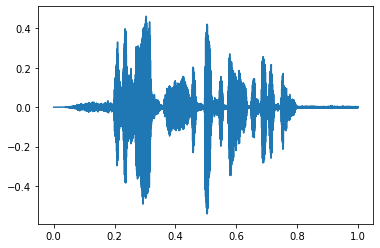

In [ ]:
# ORIGINAL VISUALISATION
plot_spec(wav,sr,'Original wave file',filename)

In [ ]:
wav,sr = librosa.load(filename,sr = None)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


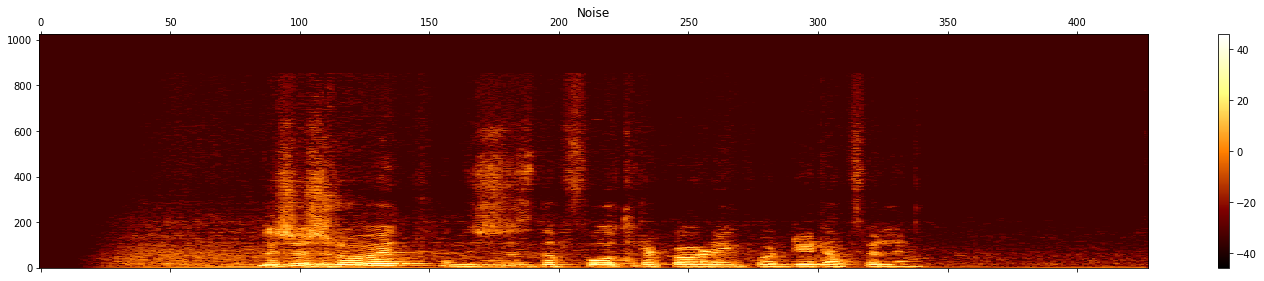

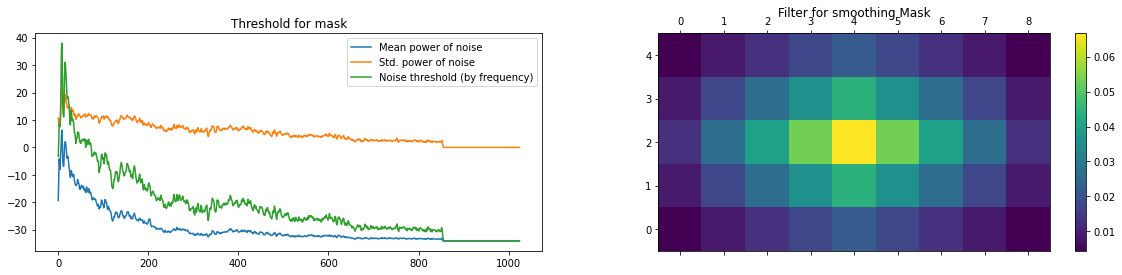

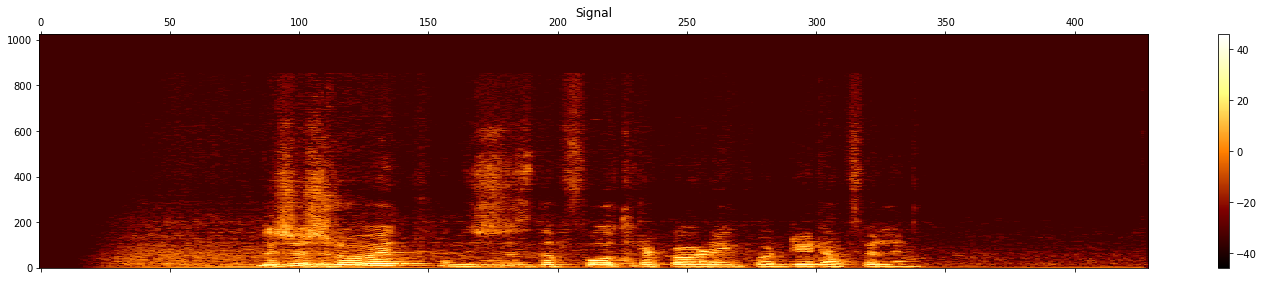

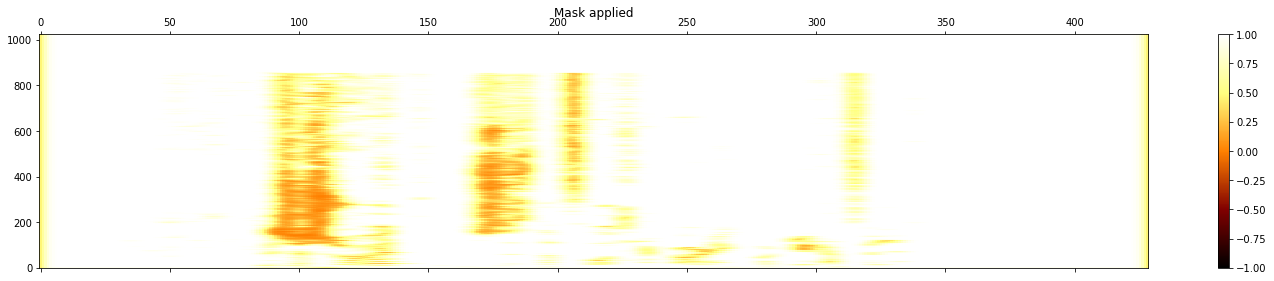

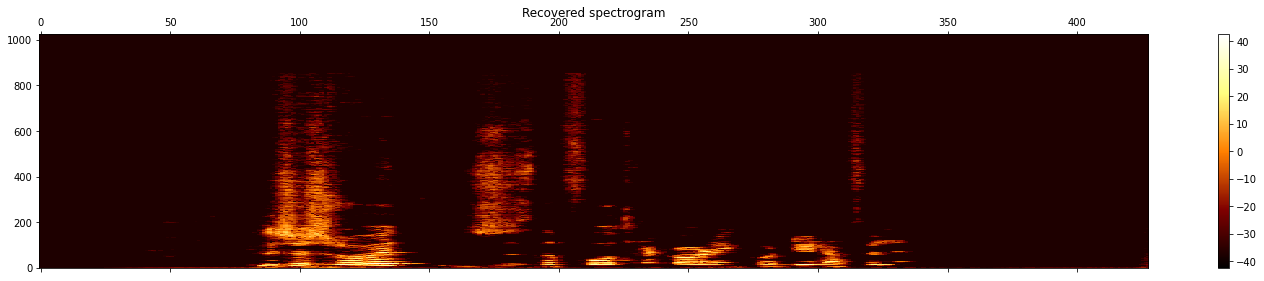

<class 'numpy.ndarray'>


In [ ]:
noisy_part = wav[0:]
# perform noise reduction
reduced_noise = nr.reduce_noise(audio_clip=wav, noise_clip=noisy_part, verbose=True)
print(type(reduced_noise))

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=49000)

In [ ]:
data=reduced_noise
scaled = np.int16(data/np.max(np.abs(data)) * 32767)
write(filename, 49000, scaled)

In [ ]:
IPython.display.Audio(filename=filename, rate=49000)

In [ ]:
wav,sr = librosa.load(filename,sr = None)


5138


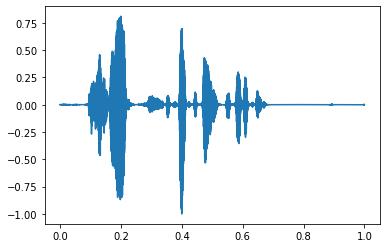

In [ ]:
# TIME SHIFTING
wav_roll = np.roll(wav,int(sr*4))
plot_spec(data=wav_roll,sr=sr,title=f'Shifting the wave by Times {sr*4}',fpath=filename)
num = random.randint(0,10000)
filename1='gdrive/My Drive/Voice Inputs/'+speaker+"/"+speaker+"_"+str(num)+".wav"
print(num)
sf.write(file=filename1, data=wav_roll,samplerate=sr)
IPython.display.Audio(wav_roll,rate=sr) # use this command to hear the modified audio file
# time shifting by a factor of sample rate*4, wave gets shifted to the right


1267
2188
4782
7081


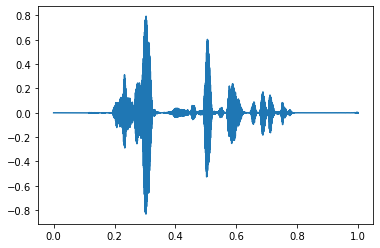

In [ ]:
# TIME STRETCHING
factors = [0.81, 0.93, 1.07, 1.23]
for factor in factors:
  wav_time_stch = librosa.effects.time_stretch(wav,factor)
  num = random.randint(0,10000)
  filename1='gdrive/My Drive/Voice Inputs/'+speaker+"/"+speaker+"_"+str(num)+".wav"
  print(num)
  sf.write(file=filename1, data=wav_time_stch,samplerate=sr)
plot_spec(data=wav_time_stch,sr=sr,title=f'Stretching the time by {factor}',fpath=filename)
IPython.display.Audio(wav_time_stch,rate=sr)

# changing the speed/duration of sound without affecting the pitch of sound
# 4 additional data files are generated from the original input

1373
3700
215
9973


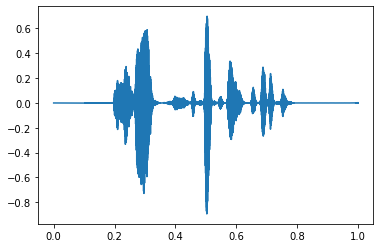

In [ ]:
# PITCH SHIFTING
pitches = [-0.2,-0.1,0.1,0.2]
for pitch in pitches:
  wav_pitch_sf = librosa.effects.pitch_shift(wav,sr,n_steps=pitch)
  num = random.randint(0,10000)
  filename1='gdrive/My Drive/Voice Inputs/'+speaker+"/"+speaker+"_"+str(num)+".wav"
  print(num)
  sf.write(file=filename1, data=wav_pitch_sf,samplerate=sr)
plot_spec(data=wav_pitch_sf,sr=sr,title=f'Pitch shifting by {pitch} steps',fpath=filename)
IPython.display.Audio(wav_pitch_sf,rate=sr)
#  changing the pitch of sound without affect it’s speed
# 4 additional data files are generated from the original input

6349


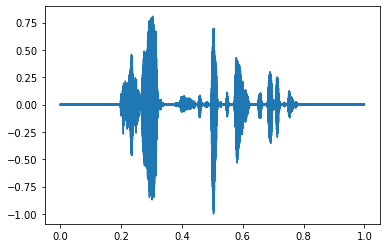

In [ ]:
# NOISE ADDITION
wav_n = wav + 0.0009*np.random.normal(0,1,len(wav))
plot_spec(wav_n,sr,'Noise Added 0.005',filename)
num = random.randint(0,10000)
filename1='gdrive/My Drive/Voice Inputs/'+speaker+"/"+speaker+"_"+str(num)+".wav"
print(num)
sf.write(file=filename1, data=wav_n,samplerate=sr)
IPython.display.Audio(data=wav_n,rate=sr)
# addition of white noise